<br><br><br><br>
<h4><b>Dataset-creation</b></h4>
<br><br>

<pre>  
<b>1. Environment setup-used</b>
              M1-Macbook
<br>
<b>2. Notebook Flow</b>
      <b>2.1 File Read</b>
    
      <b>2.2 Merging different datasets to form Training & Test datasets</b>
              a. X & Y : To combine all the datasets: 
                    'Soc_Dem', 
                    'Products_ActBalance', 
                    'Inflow_Outflow', 
                    'Sales_Revenues'
                based on Client_ID
 
      <b>2.3 Pre-processing of Training dataset</b>
              a. Basic understanding of the data 
                    - Sample data display
                    - No of observations 
                    - Datatype of the features
              b. Inspecing missing values/nan, if there is any
              c. Removal (or) replacing missing values/nan if necessary 
              d. Duplicates removal
              e. Assigning numerical value for categorical feature: 'Sex'
  
      <b>2.4 Feature engineering of training dataset</b>
              a. Checking for correlation 
                    <i>#---- Why: To remove the highly correlated variables, therey by reducing data dimensions</i>
                    <i>#---- Lead to PCA </i>
    
              b. Cdf (or) Cumulative density function to check for outliers  
                    <i>#---- Why: To either drop (or) handle them by scaling the data features </i>
                    <i>#---- Led to applying StandardScaler, RobustScaler; It aids mitigating gradient vanishing (or)
                             gradient exploding problems. In addition to that, it accelerates optimization</i>

              c. Splitting training data to X and Y
              d. Applying Scalers 
              c. Dimensionality reduction - PCA

      <b>2.5 Prepping test dataset </b>
    
      <b>2.6 Dumping the datasets</b>

<br>
</pre>

In [1]:
import numpy as np
import pandas as pd
import os

#----- Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sb
bold_s = '\033[1m' #----- To print bold font
bold_e = '\033[0m'

#----- Pre-Processing & Feature Engineering
from Data_Analysis.utils import Preprocess, file_read
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

#----- Stats
from scipy.stats import norm


<br><br><br>
<h4><b>2.1 File Read</b></h4>
<pre>
File reading of all datasets
</pre>

In [2]:
#----- File reading
datasets = ['Soc_Dem','Products_ActBalance','Inflow_Outflow', 'Sales_Revenues']
for i in datasets:
    vars()[i] = file_read(i)

#----- Printing datasets shapes
print(f'\n#----- {bold_s} List of datasets and their shape{bold_e} ')
for i in datasets:
    print(i,' shape : ', vars()[i].shape)


#-----  List of datasets and their shape 
Soc_Dem  shape :  (1615, 4)
Products_ActBalance  shape :  (1615, 13)
Inflow_Outflow  shape :  (1587, 15)
Sales_Revenues  shape :  (969, 7)


<br><br><br>
<h4><b>2.2 Merging different datasets to form Training and Test dataset</b></h4>
<pre>
a. X & Y : To combine all the datasets: 
                        'Soc_Dem', 
                        'Products_ActBalance', 
                        'Inflow_Outflow', 
                        'Sales_Revenues'
    
            based on Client_ID    
</pre>

In [3]:
#----- Creating Training dataset

#----- a. Merging all based on client id
train_data = pd.merge( Soc_Dem, Products_ActBalance, on = 'Client').merge(Inflow_Outflow, on='Client').merge(Sales_Revenues, on= 'Client')
print(f'\n#----- Training data size: {train_data.shape}')


#----- Training data size: (951, 36)


In [4]:
#----- Creating Test dataset
#----- a. Identifying the non-intersected Client id between 'Sale_Revenues' & 'Soc_Dem'

temp = pd.merge(Soc_Dem['Client'], Sales_Revenues['Client'], on ='Client', how = 'outer', indicator = True)
test_clientID = temp['Client'][temp['_merge'] != 'both' ]

test_data = pd.merge(Soc_Dem, test_clientID, on = 'Client').merge(Products_ActBalance, on = 'Client').merge(Inflow_Outflow, on = 'Client')
print(f'\n#----- Test data size: {train_data.shape}')


#----- Test data size: (951, 36)


<br><br><br>
<h4><b>2.3 Merging different datasets</b></h4>
<pre>
              a. Basic understanding of the data 
                    - Sample data display
                    - No of observations 
                    - Datatype of the features
              b. Inspecing missing values/nan, if there is any
              c. Removal (or) replacing missing values/nan if necessary 
              d. Duplicates removal
              e. Assigning numerical value for categorical feature: 'Sex'
              f. Converting features like Count_CA, Count_MF from floats to int (supposed to be)
</pre>

In [5]:
#----- a. Basic understanding of the training data
preprocess = Preprocess()

preprocess.display_data(train_data,' Training dataset', 5)



#----- Displaying top 5 rows of data-group: Training dataset


,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0.000000,0.000000,0.000000
1,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,...,6,0,0,1,0,1,0,0.000000,0.893929,0.000000
2,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,...,38,1,26,11,1,0,0,4.929643,0.000000,0.000000
3,1038,M,29,106,1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,225,M,14,187,1,NaN,NaN,1.0,NaN,NaN,...,5,0,4,1,0,0,1,0.000000,0.000000,8.130714



#----- No.of observations
951

#----- features' datatypes and other info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        951 non-null    int64  
 1   Sex                           949 non-null    object 
 2   Age                           951 non-null    int64  
 3   Tenure                        951 non-null    int64  
 4   Count_CA                      951 non-null    int64  
 5   Count_SA                      265 non-null    float64
 6   Count_MF                      183 non-null    float64
 7   Count_OVD                     251 non-null    float64
 8   Count_CC                      110 non-null    float64
 9   Count_CL                      79 non-null     float64
 10  ActBal_CA                     951 non-null    float64
 11  ActBal_SA                     265 non-null    flo

In [6]:
#----- b. Inspecting missing values
preprocess.inspect_missing_values(train_data)



#----- Inspecting missing values
Client                            0
Sex                               2
Age                               0
Tenure                            0
Count_CA                          0
Count_SA                        686
Count_MF                        768
Count_OVD                       700
Count_CC                        841
Count_CL                        872
ActBal_CA                         0
ActBal_SA                       686
ActBal_MF                       768
ActBal_OVD                      700
ActBal_CC                       841
ActBal_CL                       872
VolumeCred                        0
VolumeCred_CA                     0
TransactionsCred                  0
TransactionsCred_CA               0
VolumeDeb                         0
VolumeDeb_CA                      0
VolumeDebCash_Card                0
VolumeDebCashless_Card            0
VolumeDeb_PaymentOrder            0
TransactionsDeb                   0
TransactionsDeb_CA           

In [7]:
#----- c. Removing missing values for sex - 2 records are removed out of 951 observations
preprocess.remove_missing_values(train_data, 'Sex') #----- Removed since, 2 records are missing

#----- c. Replacing all the remaining missing values to 0's
preprocess.replace_missing_values(train_data)



#----- Inspecting missing values
Client                            0
Sex                               0
Age                               0
Tenure                            0
Count_CA                          0
Count_SA                        685
Count_MF                        766
Count_OVD                       698
Count_CC                        839
Count_CL                        870
ActBal_CA                         0
ActBal_SA                       685
ActBal_MF                       766
ActBal_OVD                      698
ActBal_CC                       839
ActBal_CL                       870
VolumeCred                        0
VolumeCred_CA                     0
TransactionsCred                  0
TransactionsCred_CA               0
VolumeDeb                         0
VolumeDeb_CA                      0
VolumeDebCash_Card                0
VolumeDebCashless_Card            0
VolumeDeb_PaymentOrder            0
TransactionsDeb                   0
TransactionsDeb_CA           

<br>
<pre>
<b>Based on the review, when the Count_account features(Count_CA...) are not filled, their corresponding ActBal values are also missing. This suggests that if a client account does not exist or hasn’t been opened, the associated account balance is likewise unavailable.</b>

Observed evidence can be seen above:

count {'Count_SA' = NaN } == count{ 'ActBal_SA' = NaN }
count {'Count_MF' = NaN } == count{ 'ActBal_MF' = NaN }
count {'Count_OVD' = NaN } == count{ 'ActBal_OVD' = NaN }
count {'Count_CC' = NaN } == count{ 'ActBal_CC' = NaN } 
count {'Count_CL' = NaN } == count{ 'ActBal_CL' = NaN } 

Therefore aforementioned missing values of features are replaced with 0

</pre>

In [8]:
#----- d. duplicate removal
print(f'\n{bold_s}#----- Checks for presence of duplicate records{bold_e}')
train_data.duplicated().sum()


#----- Checks for presence of duplicate records


0

In [9]:
#----- e. Assigning numerical value for categorical feature: 'Sex'
train_data['Sex'] = train_data['Sex'].astype('category').cat.codes
train_data['Sex'] = train_data['Sex'].astype('int')
print(f'\n{bold_s}#----- Numeric values to Categorical features{bold_e}')
print('Males are encoded -> 1, Females are encoded as 0\n\n')

train_data.head(5)


#----- Numeric values to Categorical features
Males are encoded -> 1, Females are encoded as 0




,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,1,38,165,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0.000000,0.000000,0.000000
1,850,0,49,44,1,0.0,0.0,0.0,0.0,0.0,...,6,0,0,1,0,1,0,0.000000,0.893929,0.000000
2,1473,1,54,34,1,1.0,0.0,0.0,1.0,1.0,...,38,1,26,11,1,0,0,4.929643,0.000000,0.000000
3,1038,1,29,106,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,225,1,14,187,1,0.0,0.0,1.0,0.0,0.0,...,5,0,4,1,0,0,1,0.000000,0.000000,8.130714


<br><br><br>
<h4><b>2.4 Feature engineering</b></h4>
<pre>      
    
              a. Checking for correlation
              b. cdf for outliers
              c. Splitting training data to X and Y
              d. Applying Scalers 
              e. Dimensionality reduction - PCA
</pre> 

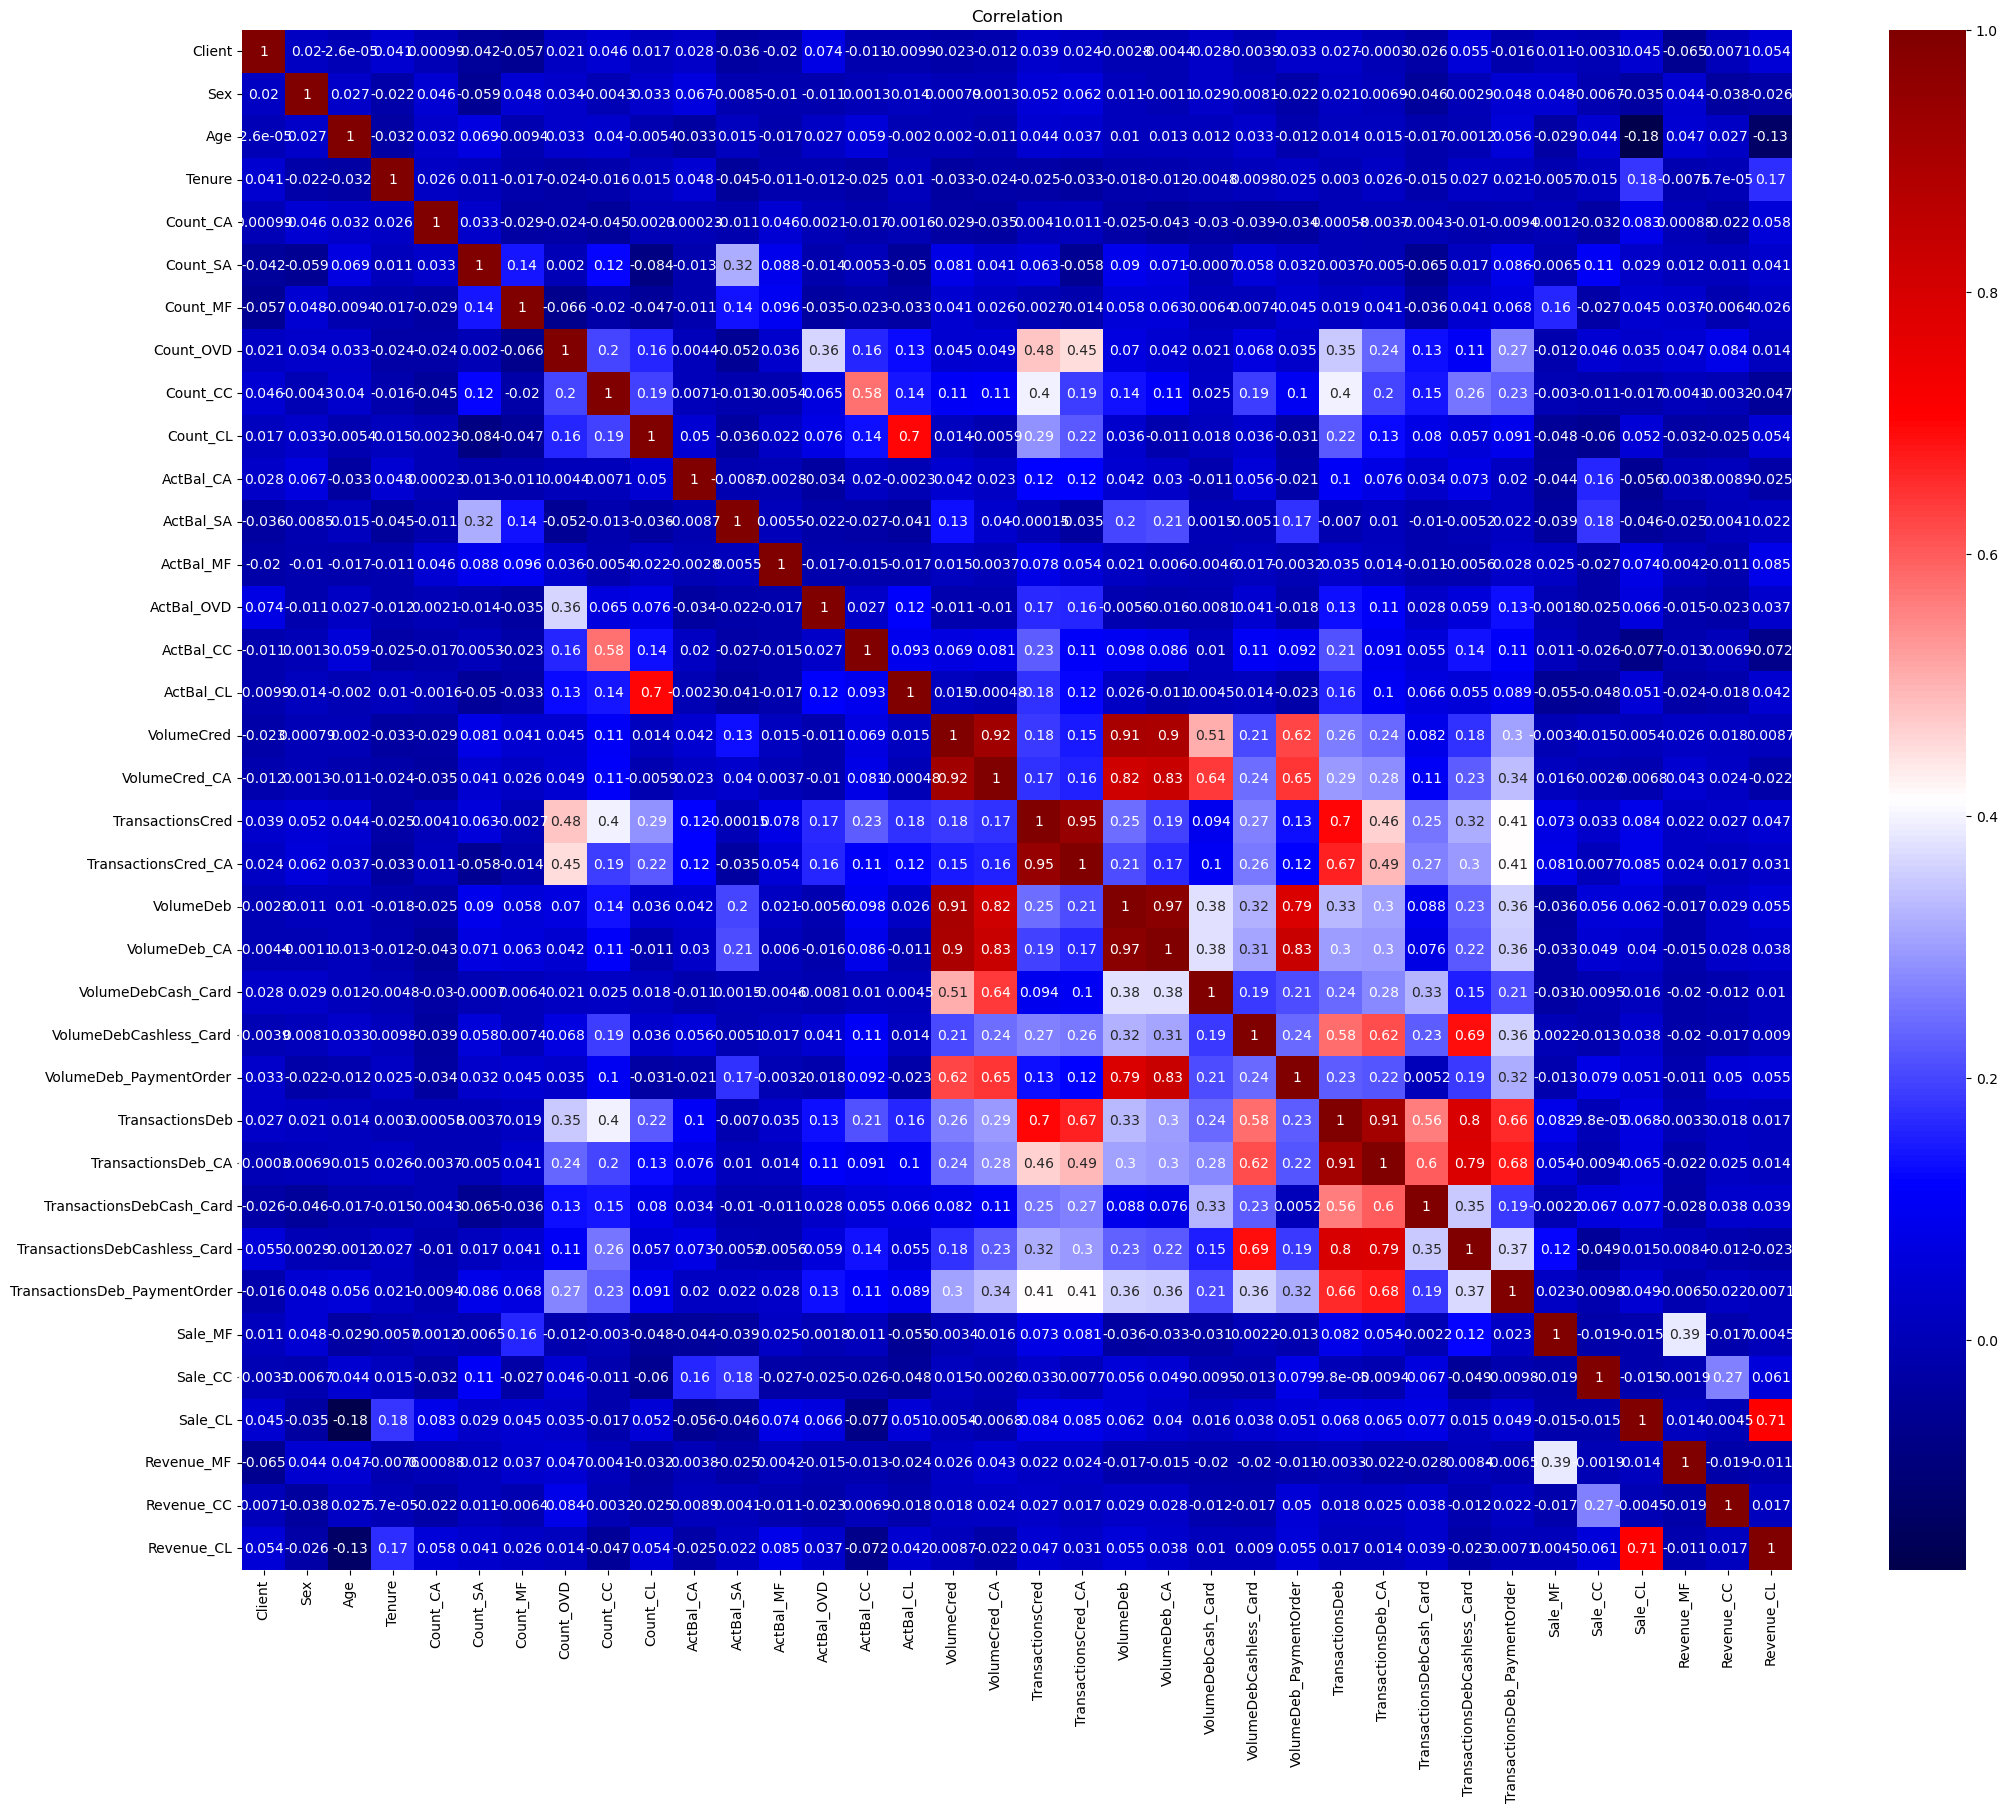

In [10]:
#----- a. Checking for correlation : To check for dependency between the input variables
#-----    Thereby removing the highly correlated features (if there is any) to reduce the data dimensions

corr = train_data.corr()

plt.figure(figsize = (25,20))
sb.heatmap(corr, annot=True, cmap='seismic')
plt.title("Correlation")
plt.show()

<br>
<pre><b>
Since the correlated value didn't surpass the assumed threshold: 0.95. No features got removed directly. But will be handled in subsequently via PCA </b>
</pre>

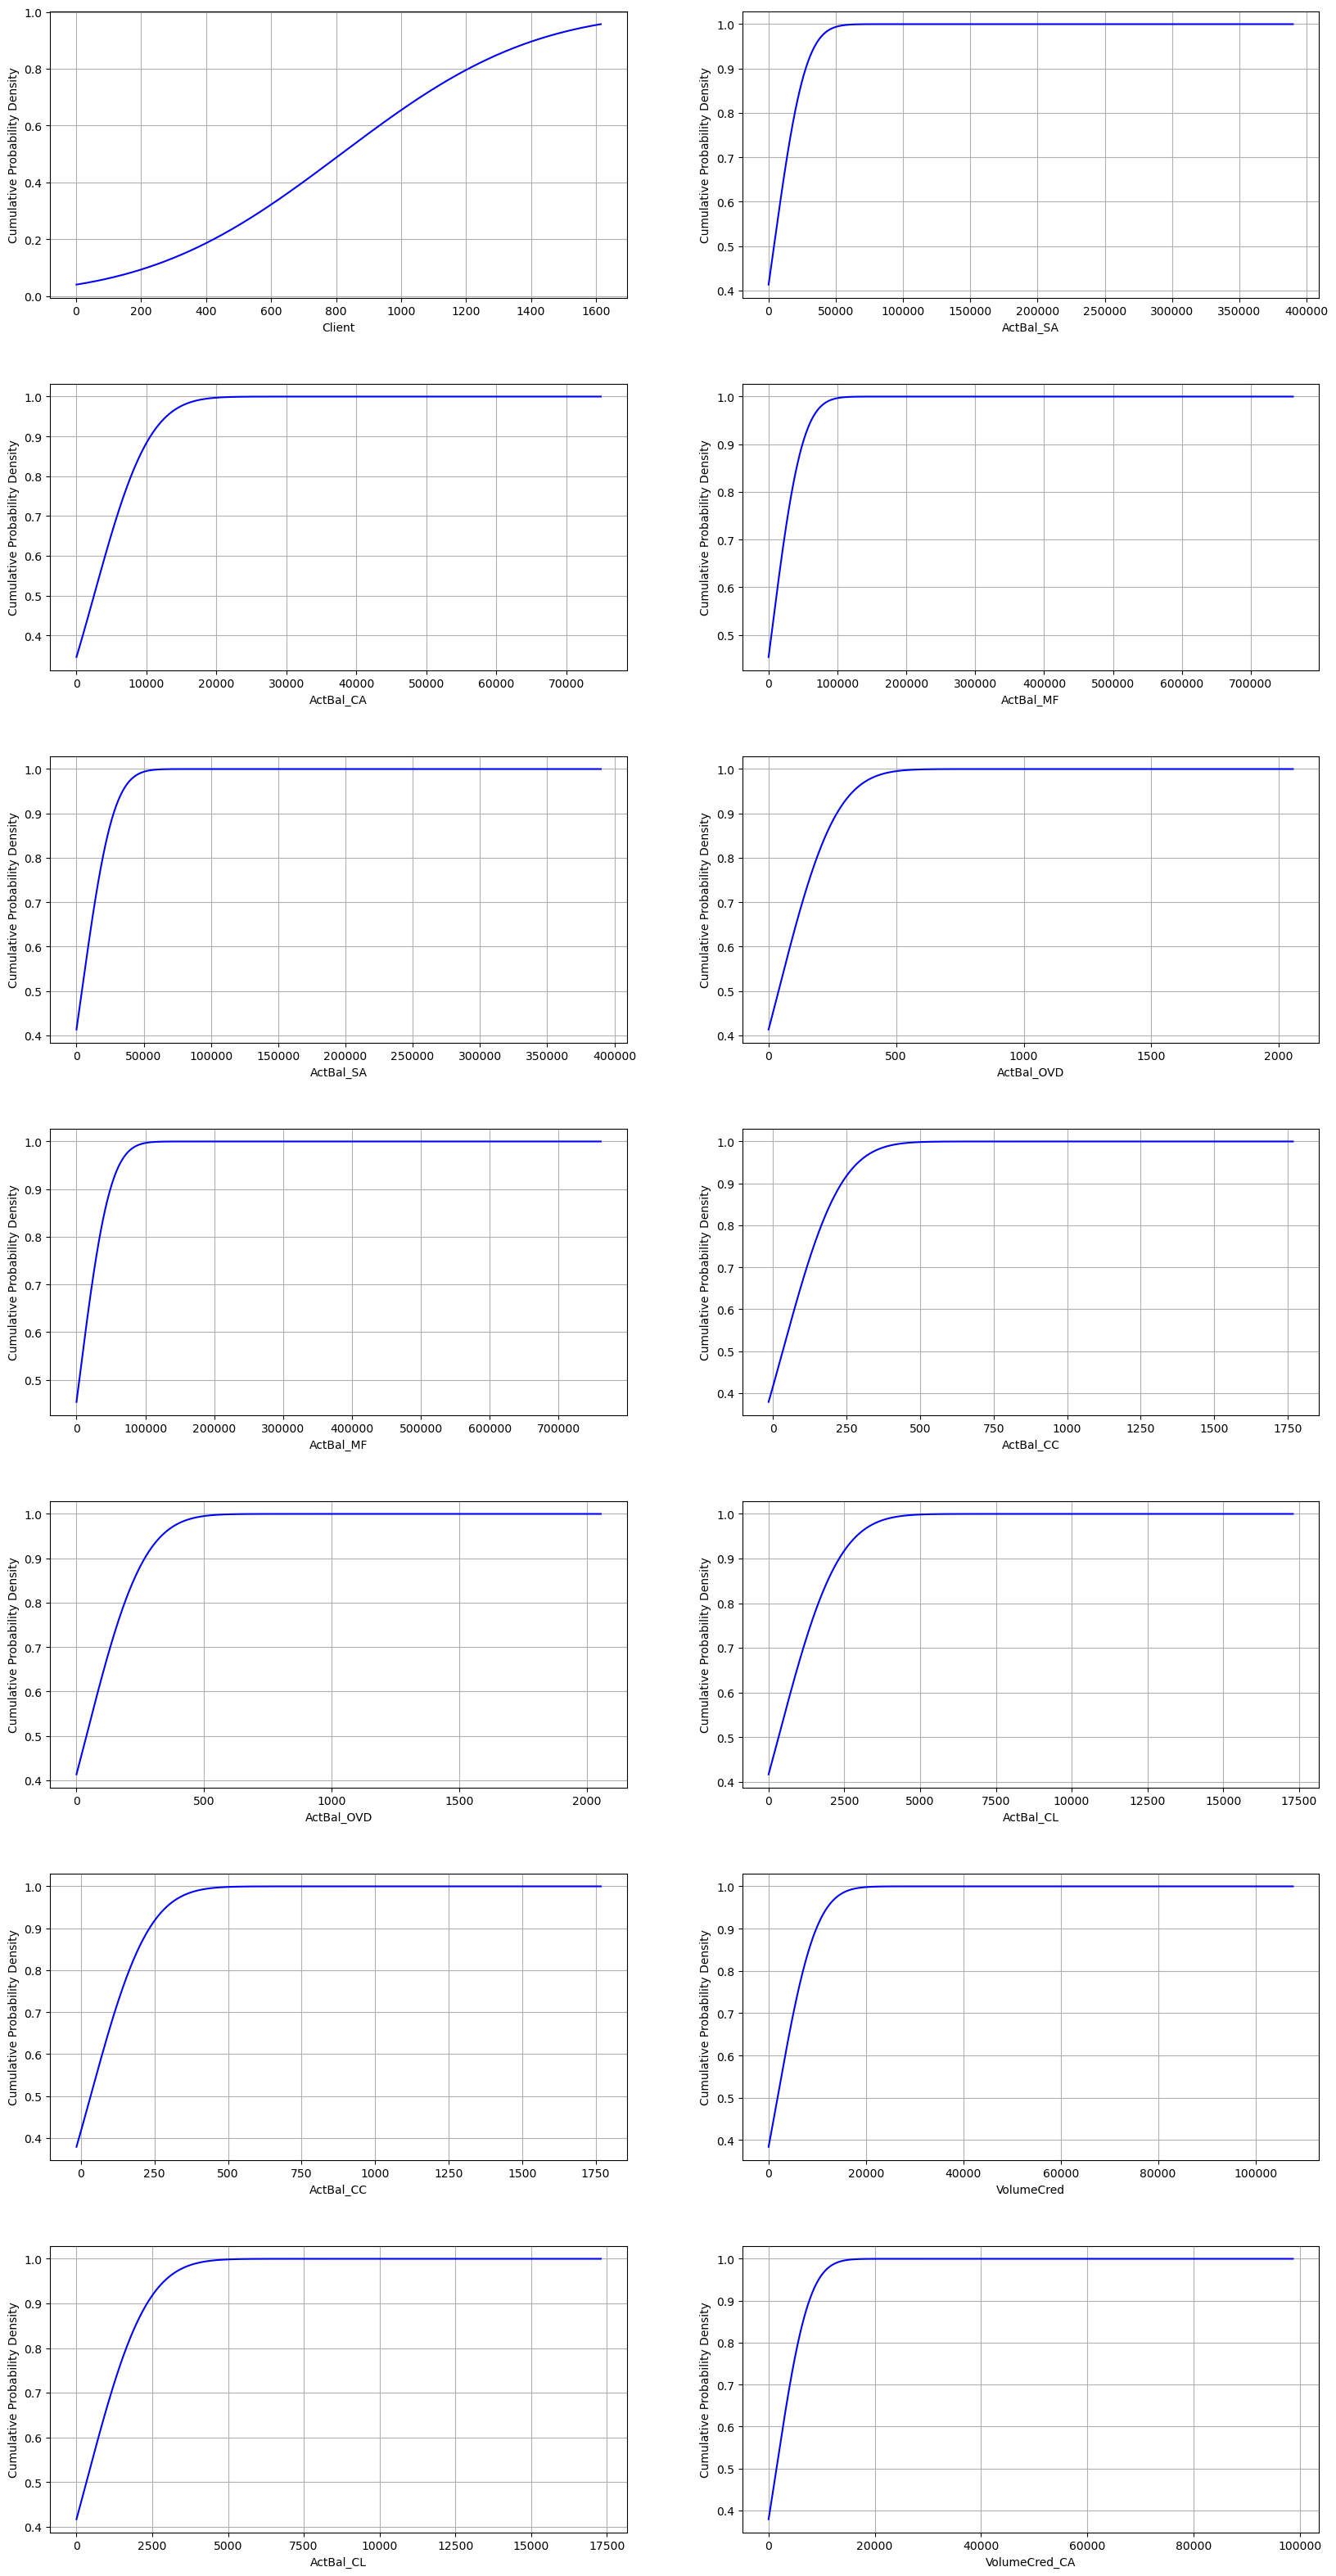

In [11]:
#----- b. CDF to find outliers

columns = train_data.columns
columns_std_above_100 = columns[ list(train_data.std()> 100) ]

#----- Graphing
fig, axs = plt.subplots(7,2, figsize = (20,40))
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)

for i in range(0,7):
    for j in range(0,2): 
        feature = columns_std_above_100[(i) + (2*j)]  
        feature_data = train_data[feature]
    
        mean, std = norm.fit(feature_data)
        x = np.linspace(min(feature_data), max(feature_data), 1000)
        y = norm.pdf(x, mean,std)
        
        cdf = norm.cdf(x, mean,std)
        
        axs[i,j].plot(x, cdf, color='blue')
        axs[i,j].set(xlabel = feature, ylabel = 'Cumulative Probability Density')
        axs[i,j].grid(True)
        
plt.show()

<br>
<pre>
<b> CDF confirms the presence of outliers ( feature having huge standard deviation value > 1000 ).So, features will be handled by rescaling.
</b>
</pre>

In [12]:
#----- c. Splitting training data to X and Y

target = ['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'  ]
input_var = list(train_data.columns)[1:-6]

train_y = train_data[target]
train_x = train_data[input_var]

print(f'\n{bold_s}#----- Training dataset X Shape: {train_x.shape}{bold_e}')
print(f'\n{bold_s}#----- Training dataset Y Shape: {train_y.shape}{bold_e}')


#----- Training dataset X Shape: (949, 29)

#----- Training dataset Y Shape: (949, 7)


In [14]:
#----- d. Applying Scalers

#----- Standard scaler
scaler_std = StandardScaler()
scaled_std_data_x = scaler_std.fit_transform(train_x)

#----- Robust scaler
scaler_robust = RobustScaler()
scaler_robust_data_x = scaler_robust.fit_transform(train_x)


In [15]:
#----- e. Diemnsionality Reduction via PCA

#----- For plain data
pca = PCA(0.99) 
pca_result = pca.fit_transform(train_x)
print(f'\n{bold_s}#----- PCA on training data{bold_e}')
print(f'(#training records, #pca components): {pca_result.shape}')

#----- For Standar Scaler applied data
pca_ss = PCA(0.99)
pca_ss_result = pca_ss.fit_transform(scaled_std_data_x)
print(f'\n{bold_s}#----- PCA on StandardScaler applied training data{bold_e}')
print(f'(#training records, #pca components): {pca_ss_result.shape}')

#----- For Robust Scaler applied data
pca_rs = PCA(0.99)
pca_rs_result = pca.fit_transform(scaler_robust_data_x)
print(f'\n{bold_s}#----- PCA on RobustScaler applied training data{bold_e}')
print(f'(#training records, #pca components): {pca_rs_result.shape}')



#----- PCA on training data
(#training records, #pca components): (949, 4)

#----- PCA on StandardScaler applied training data
(#training records, #pca components): (949, 23)

#----- PCA on RobustScaler applied training data
(#training records, #pca components): (949, 2)


<br><br><br>
<h4><b>2.5 Prepping test dataset</b></h4>


In [26]:
#----- Following the procedure same 
preprocess.display_data(test_data,'Test data', 5)
preprocess.remove_missing_values(test_data, 'Sex')
preprocess.replace_missing_values(test_data)

test_data['Sex'] = test_data['Sex'].astype('category').cat.codes
test_data['Sex'] = test_data['Sex'].astype('int')

test_data.head(5)



#----- Displaying top 5 rows of data-group:Test data


,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,909,M,21,27,1,0.0,0.0,1.0,0.0,1.0,...,450.678571,448.892857,178.571429,0.000000,166.571429,8,7,1,0,4
1,699,M,37,175,1,0.0,4.0,1.0,0.0,0.0,...,661.483214,566.126071,89.285714,0.000000,216.892857,13,10,2,0,5
2,528,F,19,70,1,0.0,0.0,1.0,0.0,0.0,...,390.056429,390.056429,125.000000,70.842143,190.821429,10,10,4,3,2
3,1145,M,61,45,1,0.0,0.0,0.0,0.0,0.0,...,3.392857,3.392857,0.000000,0.000000,0.000000,1,1,0,0,0
4,517,F,41,28,1,0.0,0.0,0.0,0.0,0.0,...,557.896429,557.896429,71.428571,224.146429,251.178571,17,17,2,10,3



#----- No.of observations
635

#----- features' datatypes and other info
<class 'pandas.core.frame.DataFrame'>
Index: 635 entries, 0 to 635
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        635 non-null    int64  
 1   Sex                           635 non-null    object 
 2   Age                           635 non-null    int64  
 3   Tenure                        635 non-null    int64  
 4   Count_CA                      635 non-null    int64  
 5   Count_SA                      635 non-null    float64
 6   Count_MF                      635 non-null    float64
 7   Count_OVD                     635 non-null    float64
 8   Count_CC                      635 non-null    float64
 9   Count_CL                      635 non-null    float64
 10  ActBal_CA                     635 non-null    float64
 11  ActBal_SA                     635 non-null    float64


,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,909,1,21,27,1,0.0,0.0,1.0,0.0,1.0,...,450.678571,448.892857,178.571429,0.000000,166.571429,8,7,1,0,4
1,699,1,37,175,1,0.0,4.0,1.0,0.0,0.0,...,661.483214,566.126071,89.285714,0.000000,216.892857,13,10,2,0,5
2,528,0,19,70,1,0.0,0.0,1.0,0.0,0.0,...,390.056429,390.056429,125.000000,70.842143,190.821429,10,10,4,3,2
3,1145,1,61,45,1,0.0,0.0,0.0,0.0,0.0,...,3.392857,3.392857,0.000000,0.000000,0.000000,1,1,0,0,0
4,517,0,41,28,1,0.0,0.0,0.0,0.0,0.0,...,557.896429,557.896429,71.428571,224.146429,251.178571,17,17,2,10,3


<br><br><br>
<h4><b>2.5 Saving training data into excel</b></h4>


In [25]:
train_data.to_excel('./train_data.xlsx', index = False)
test_data.to_excel('./test_data.xlsx', index = False)